<a href="https://colab.research.google.com/github/wisnusnugroho/Indeks-Pencemaran-JKT/blob/master/Final%20Profect%20BDA%20-%20DTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Final Project DTS - BDA**

Name : 

1.   Wisnu Setia Nugroho
2.   Yeyen Puji Astanto



In [0]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d')
dataset = read_csv('https://raw.githubusercontent.com/wisnusnugroho/Indeks-Pencemaran-JKT/master/ISPU-SPKU-JANUARI-DESEMBER-2017.csv',  parse_dates = [['tahun', 'bulan', 'tanggal']], index_col=0, date_parser=parse, error_bad_lines=False)
dataset.drop(['wilayah','max','critical','kategori'], axis=1, inplace=True)
# manually specify column names
dataset.columns = ['partikular_udara', 'sulfur_dioksida', 'co', 'ozon', 'nitrogen_oksida']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['partikular_udara'].fillna(0, inplace=True)
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')


            partikular_udara  sulfur_dioksida  co  ozon  nitrogen_oksida
date                                                                    
2017-01-01              63.0               34  25    21                2
2017-01-02              16.0               32  16    19                1
2017-01-03              18.0               32  17    20                2
2017-01-04              24.0               32  22    20                2
2017-01-05              29.0               32  25    14                2


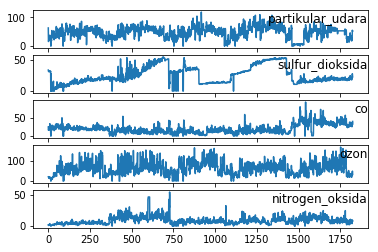

In [0]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [0]:
dataset.info()
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2017-01-01 to 2017-12-31
Data columns (total 5 columns):
partikular_udara    1825 non-null float64
sulfur_dioksida     1825 non-null int64
co                  1825 non-null int64
ozon                1825 non-null int64
nitrogen_oksida     1825 non-null int64
dtypes: float64(1), int64(4)
memory usage: 85.5 KB


,partikular_udara,sulfur_dioksida,co,ozon,nitrogen_oksida
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,47.624658,25.859726,19.015342,62.944658,9.094247
std,19.403239,13.792440,11.775997,30.523138,6.323939
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,15.000000,11.000000,40.000000,5.000000
50%,52.000000,20.000000,17.000000,61.000000,8.000000
75%,60.000000,34.000000,25.000000,84.000000,12.000000
max,118.000000,55.000000,93.000000,168.000000,55.000000


**Multivariate LSTM Forecast Model**

Normalisasi Data

In [0]:
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.533898   0.618182   0.268817   0.128049   0.071429  0.135593
2   0.135593   0.581818   0.172043   0.115854   0.035714  0.152542
3   0.152542   0.581818   0.182796   0.121951   0.071429  0.203390
4   0.203390   0.581818   0.236559   0.121951   0.071429  0.245763
5   0.245763   0.581818   0.268817   0.085366   0.071429  0.177966


**Model LSTM**

In [0]:
# split into train and test sets
values = reframed.values
n_train_day = 365
train = values[:n_train_day, :]
test = values[n_train_day:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(365, 1, 5) (365,) (1459, 1, 5) (1459,)


**training model**

**Serta Grafik**

Train on 365 samples, validate on 1459 samples
Epoch 1/50
 - 4s - loss: 0.3440 - val_loss: 0.3509
Epoch 2/50
 - 0s - loss: 0.3062 - val_loss: 0.3073
Epoch 3/50
 - 0s - loss: 0.2658 - val_loss: 0.2627
Epoch 4/50
 - 0s - loss: 0.2238 - val_loss: 0.2175
Epoch 5/50
 - 0s - loss: 0.1808 - val_loss: 0.1737
Epoch 6/50
 - 0s - loss: 0.1401 - val_loss: 0.1362
Epoch 7/50
 - 0s - loss: 0.1068 - val_loss: 0.1121
Epoch 8/50
 - 0s - loss: 0.0889 - val_loss: 0.1063
Epoch 9/50
 - 0s - loss: 0.0829 - val_loss: 0.1103
Epoch 10/50
 - 0s - loss: 0.0832 - val_loss: 0.1139
Epoch 11/50
 - 0s - loss: 0.0836 - val_loss: 0.1134
Epoch 12/50
 - 0s - loss: 0.0829 - val_loss: 0.1107
Epoch 13/50
 - 0s - loss: 0.0820 - val_loss: 0.1083
Epoch 14/50
 - 0s - loss: 0.0816 - val_loss: 0.1070
Epoch 15/50
 - 0s - loss: 0.0814 - val_loss: 0.1063
Epoch 16/50
 - 0s - loss: 0.0814 - val_loss: 0.1062
Epoch 17/50
 - 0s - loss: 0.0813 - val_loss: 0.1061
Epoch 18/50
 - 0s - loss: 0.0810 - val_loss: 0.1062
Epoch 19/50
 - 0s - loss: 

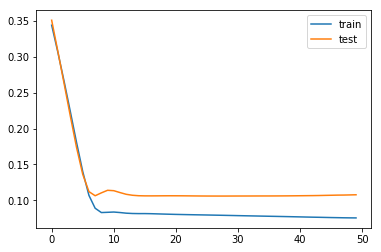

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Nilai Kesalahan Model**

In [0]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#define MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#define MAD
def mean_absolute_deviation(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))
  
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#MSE
MSE = mean_squared_error(inv_y, inv_yhat)
print('Test MSE  : %.3f' % MSE)

#MAPE
MAPE = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Test MAPE : %.3f' % MAPE, '%')

#MAD
MAD = mean_absolute_deviation(inv_y, inv_yhat)
print('Test MAD  : %.3f' % MAD)

Test RMSE: 16.445
Test MSE  : 270.432
Test MAPE : inf %
Test MAD  : 12.705


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


**file complete analisis multivariat LSTM**

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.533898   0.618182   0.268817   0.125000   0.052632  0.135593
2   0.135593   0.581818   0.172043   0.113095   0.026316  0.152542
3   0.152542   0.581818   0.182796   0.119048   0.052632  0.203390
4   0.203390   0.581818   0.236559   0.119048   0.052632  0.245763
5   0.245763   0.581818   0.268817   0.083333   0.052632  0.177966
(365, 1, 5) (365,) (1459, 1, 5) (1459,)
Train on 365 samples, validate on 1459 samples
Epoch 1/50
 - 3s - loss: 0.3779 - val_loss: 0.3702
Epoch 2/50
 - 0s - loss: 0.3400 - val_loss: 0.3265
Epoch 3/50
 - 0s - loss: 0.3001 - val_loss: 0.2825
Epoch 4/50
 - 0s - loss: 0.2589 - val_loss: 0.2378
Epoch 5/50
 - 0s - loss: 0.2164 - val_loss: 0.1946
Epoch 6/50
 - 0s - loss: 0.1738 - val_loss: 0.1554
Epoch 7/50
 - 0s - loss: 0.1347 - val_loss: 0.1248
Epoch 8/50
 - 0s - loss: 0.1053 - val_loss: 0.1113
Epoch 9/50
 - 0s - loss: 0.0901 - val_loss: 0.1134
Epoch 10/50
 - 0s - loss: 0.0848 - val_loss: 0.1212


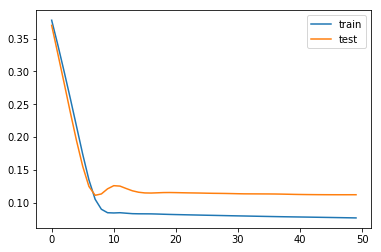

Test RMSE: 17.163
Test MSE  : 294.576
Test MAPE : inf %
Test MAD  : 13.241


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide


In [0]:
import numpy as np
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_day = 365
train = values[:n_train_day, :]
test = values[n_train_day:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#define MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#define MAD
def mean_absolute_deviation(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))
  
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#MSE
MSE = mean_squared_error(inv_y, inv_yhat)
print('Test MSE  : %.3f' % MSE)

#MAPE
MAPE = mean_absolute_percentage_error(inv_y, inv_yhat)
print('Test MAPE : %.3f' % MAPE, '%')

#MAD
MAD = mean_absolute_deviation(inv_y, inv_yhat)
print('Test MAD  : %.3f' % MAD)